실제 데이터 소스

In [1]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random

In [2]:
def generate_real():
    real_data = torch.FloatTensor(
    [random.uniform(0.8,1.0),
    random.uniform(0.0,0.2),
    random.uniform(0.8,1.0),
    random.uniform(0.0,0.2)
    ])
    return real_data

In [3]:
generate_real()

tensor([0.9282, 0.1225, 0.9853, 0.1861])

판별기 만들기

In [4]:
class Discriminator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(4,3),
            nn.Sigmoid(),
            nn.Linear(3,1),
            nn.Sigmoid()
        )
        
        # 손싫함수 설정
        self.loss_function = nn.MSELoss()
        
        # SGD 옵티마이저 설정
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # 진행 측정을 위한 변수 초기화
        self.counter = 0
        self.progress = []
        
        pass
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    def train(self, inputs, targets):
        # 신경망 출력 계산
        outputs = self.forward(inputs)
        
        # 손실 계산
        loss = self.loss_function(outputs, targets)
        
        # 카운터를 증가시키고 10회 마다 오차 저장
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ",self.counter)
            pass
        
        # 기울기를 초기화하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8),alpha=0.1, marker='.', grid = True, yticks=(0,0.25,0.5))
        pass

판별기 테스트하기

In [5]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [6]:
%%time

D = Discriminator()

for i in range(10000):
    # 실제데이터
    D.train(generate_real(), torch.FloatTensor([1.0]))
    #생성된 데이터
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
Wall time: 5.14 s


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


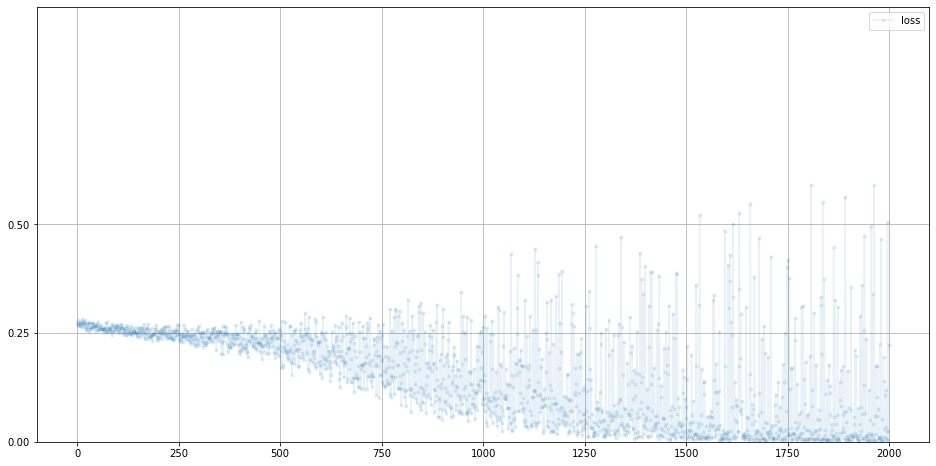

In [7]:
D.plot_progress()

In [8]:
# manually run discriminator to check it can tell real data from fake

print(D.forward( generate_real() ).item() )
print(D.forward( generate_random(4) ).item())

0.8166494965553284
0.048845015466213226


생성기 만들기

In [9]:
class Generator(nn.Module):
    
    def __init__(self):
        # 파이토치 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(1,3),
            nn.Sigmoid(),
            nn.Linear(3,4),
            nn.Sigmoid()
        )
        
        # 손실함수 설정할 필요가 없음
        # self.loss_function = nn.MSELoss()
        
        # SGD 옵티마이저 설정
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # 진행 측정을 위한 변수 초기화
        self.counter = 0
        self.progress = []
        
        pass
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        # 신경망 출력 계산
        g_output = self.forward(inputs)
        
        # 판별기로 전달
        d_output = D.forward(g_output)
        
        # 오차 계산
        loss = D.loss_function(d_output, targets)
        
        # 카운터를 증가시키고 10회 마다 오차 저장
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        
        # 기울기를 초기화하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0,1.0), figsize=(16,8),alpha=0.1, marker='.', grid = True, yticks=(0,0.25,0.5))
        pass

생성기 결과 확인하기

In [10]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.4392, 0.5408, 0.5525, 0.4827], grad_fn=<SigmoidBackward>)

GAN 훈련하기

In [11]:
%%time

# 판별기 및 생성기 생성
D = Discriminator()
G = Generator()
image_list = []
    
# 판별기와 생성기 훈련
for i in range(10000):
    
    # 1단계 : 참에 대해 판별기 훈련
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # 2단계 : 거짓에 대해 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # 3단계 : 생성기 훈련
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    # 매 1000회 이미지를 저장
    if (i%1000 == 0):
        image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

counter =  10000
counter =  20000
Wall time: 9.55 s


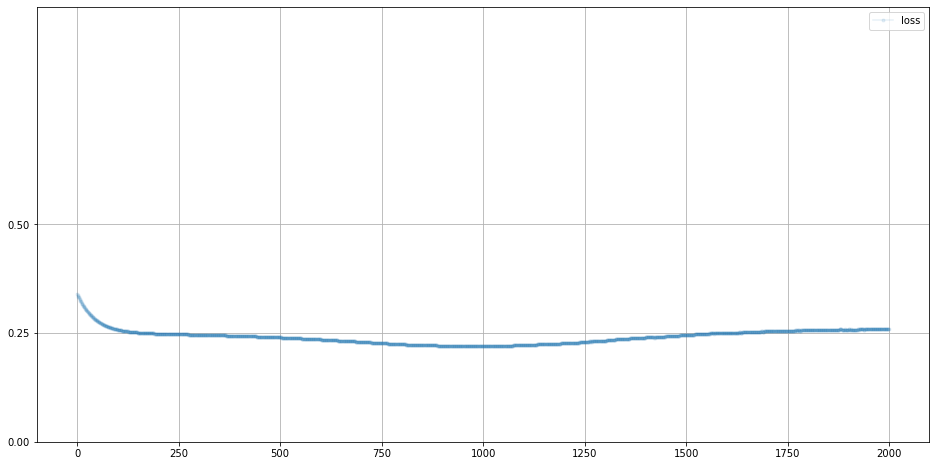

In [12]:
D.plot_progress()

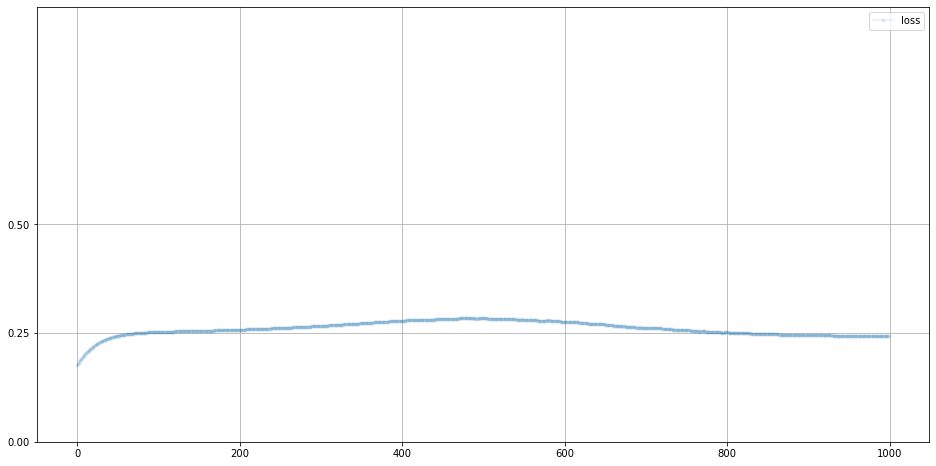

In [13]:
G.plot_progress()

In [14]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9230, 0.0651, 0.9079, 0.0608], grad_fn=<SigmoidBackward>)

In [15]:
image_list

[array([0.5158004 , 0.4610626 , 0.7287104 , 0.49519306], dtype=float32),
 array([0.5362397 , 0.46890253, 0.72977287, 0.50122374], dtype=float32),
 array([0.563127  , 0.46749663, 0.7364628 , 0.49568838], dtype=float32),
 array([0.60212857, 0.4508764 , 0.74976486, 0.47182974], dtype=float32),
 array([0.6582526 , 0.40698725, 0.7704419 , 0.41654855], dtype=float32),
 array([0.72788036, 0.32763016, 0.7975179 , 0.32366017], dtype=float32),
 array([0.79548174, 0.23214151, 0.82719773, 0.22111312], dtype=float32),
 array([0.84775716, 0.15637976, 0.85460055, 0.14598317], dtype=float32),
 array([0.88341284, 0.10944905, 0.8770513 , 0.10169185], dtype=float32),
 array([0.90705764, 0.08186834, 0.89449334, 0.07623087], dtype=float32)]

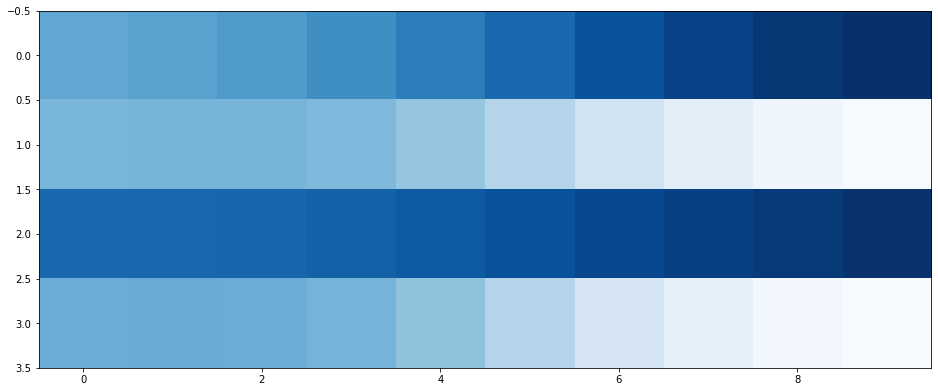

In [16]:
import numpy as np

plt.figure(figsize = (16,8))
plt.imshow(np.array(image_list).T, interpolation='none', cmap='Blues')